# Business Case: XPTO LLC.

## Data Analyst

### Candidate: Rafael Feltrin

Let's start by importing functions from the modules I wrote to perform the challenge's Parts I and II, which are respectively *etl_script.py* and *eda_script.py*.

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from scripts.eda_script import (calculate_branch_ratio,
                                compare_branches,
                                join_dfs,
                                pivot_data,
                                plot_city_data,
                                plot_correlation_matrix,
                                slice_date)
from scripts.etl_script import (create_geodf,
                                read_csv, 
                                write_associates_and_branches_cols,
                                write_database_dates)

# Part I : ETL

We must start by opening the .csv file and creating some new columns as we see fit -- they might be used here or could be nice to have in future analyses.

So we begin we the *read_csv* method, which takes the file path and already does a simple change, which is filling the root CNPJ and the full CNPJ with leading zeroes in case they are missing.

I always do that because **this sort of data tends to end up in the hands of less tech-savvy areas such as sales ops and marketing**, and it is very common for them to match these CNPJ columns with manually collected spreadsheets or CRM outputs which commonly has the leading zeroes.

In [2]:
path = r'C:\Users\rafaf\PycharmProjects\parana_irs_dataset_analysis\data\data_case_2024_03.csv'

df = read_csv(path=path,
              sep=',',
              zfill_cols=['document_number', 'cnpj_basico'])

display(df.head(3))

,document_number,cnpj_basico,establishment_type,razao_social,nome_fantasia,opening_date,cnae,cnae_description,mcc,mcc_description,total_branches_and_associates,city_state,city_code,zip_code,share_capital,size_company,juri_description,juri_description_ENG,email_provider
0,79690152000466,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,26 de novembro de 2003,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...","{""total_associates"": 8, ""total_branches"": ""12 ...",Ubiratã - PR,4128005,85440000,4750000.0,OTHER,Sociedade Empresária Limitada,Limited Liability Company (LLC),NaN
1,79690152000385,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,COMERCIAL AGRICOLA DE PARANAVAI LTDA,17 de setembro de 1976,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...","{""total_associates"": 8, ""total_branches"": ""12 ...",Loanda - PR,4113502,87900000,4750000.0,OTHER,Sociedade Empresária Limitada,Limited Liability Company (LLC),NaN
2,79690152000628,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,10 de janeiro de 1995,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...","{""total_associates"": 8, ""total_branches"": ""12 ...",Maringá - PR,4115200,87065005,4750000.0,OTHER,Sociedade Empresária Limitada,Limited Liability Company (LLC),katoagricola.com.br


We can see it works.

Next, we will convert the string-formatted to a database-friendly date format just in case we need it later. The *write_database_dates* function does that in a very **modular fashion** -- if we went back to the Roman calendar or added a new month we could only update the inputs!

Back to the real world, we input the 12 months in Portuguese and run it.

In [3]:
portuguese_months = ['janeiro', 'fevereiro', 'março', 'abril',
                     'maio', 'junho', 'julho', 'agosto', 
                     'setembro', 'outubro', 'novembro', 'dezembro']

month_numbers = [f"{i:02d}" for i in range(1, len(portuguese_months) + 1)]

months = {name: num for name, num in zip(portuguese_months, month_numbers)}

df = write_database_dates(df=df, 
                          date_col='opening_date', 
                          months=months)

display(df['formatted_opening_date'].head(3))

0    20031126
1    19760917
2    19950110
Name: formatted_opening_date, dtype: object

Another interesting column is the one with the amount of branches and associated. It is a **JSON-like structure**, and we parse it with the *write_associates_and_branches_cols* to add two new integer columns with the number of associates and branches.  

In [4]:
df = write_associates_and_branches_cols(df=df,
                                        json_col='total_branches_and_associates')

display(df[['total_associates', 'total_branches']].head(3))

,total_associates,total_branches
0,8,12
1,8,12
2,8,12


Finally, the cherry on top. Using the *geobr* package we can get **official geospatial data from IPEA**, which we will need when plotting map charts in Part II.

The *create_geodf* function reads all IBGE city codes in the dataset and gets their geometry in a GeoDataFrame format, which we will later join with a pivot table of company data to plot the maps and show business insights.   

In [5]:
gdf = create_geodf(df=df,
                   city_code_col='city_code',
                   year=2022)

display(gdf.head(3))

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,4128005.0,Ubiratã,41.0,PR,Paraná,4.0,Sul,"MULTIPOLYGON (((-52.97501 -24.34684, -52.98215..."
1,4113502.0,Loanda,41.0,PR,Paraná,4.0,Sul,"MULTIPOLYGON (((-53.04921 -23.09932, -53.04181..."
2,4115200.0,Maringá,41.0,PR,Paraná,4.0,Sul,"MULTIPOLYGON (((-51.89955 -23.30343, -51.89638..."


Now we know our GeoDataFrame works, let us move on to the next part.

# Part II: EDA

Let's start by doing some descriptive stats and correlations between variables that might be of interest if we intend to sell b2b products to the companies.

In [6]:
df[['share_capital', 'total_associates', 'total_branches']].describe()

,share_capital,total_associates,total_branches
count,9.775870e+05,977587.000000,977587.000000
mean,2.822309e+06,1.381785,2.276461
std,1.884717e+08,2.305901,25.963285
min,0.000000e+00,1.000000,1.000000
25%,1.000000e+03,1.000000,1.000000
50%,8.000000e+03,1.000000,1.000000
75%,3.000000e+04,2.000000,1.000000
max,4.110617e+10,1355.000000,1892.000000


We can notice that the total associates and total branches **are very skewed to the right side of the distribution**, with most of the values bigger than one for both branches and associates are on the last quartile.

This means that the most appropriate correlation coefficient, one more robust to massive outliers, would be the Spearman correlation and not Pearson which is the most famous one.

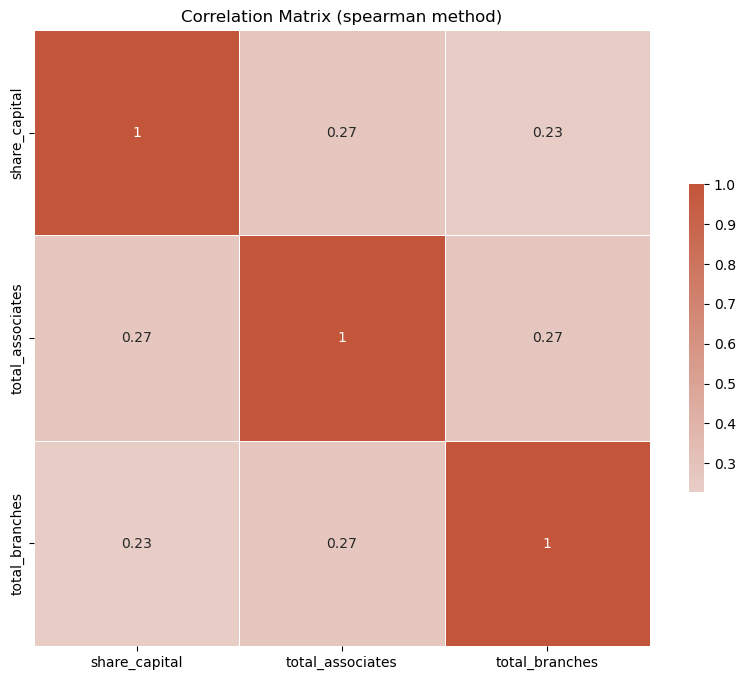

In [7]:
fig, ax = plot_correlation_matrix(df=df[['share_capital', 'total_associates', 'total_branches']],
                                  method='spearman')

fig

We can see that there is a positive correlation between three variables, but it is not very high. These relationships **would be expected**, as firms with a small share capital probably would not have a lot of associates and branches.

We can also check for missing values in all columns.

In [8]:
nan_counts = df.isna().sum()

print('Missing values:')
display(nan_counts)

Missing values:


document_number                       0
cnpj_basico                           0
establishment_type                    0
razao_social                          0
nome_fantasia                    620697
opening_date                          0
cnae                                  0
cnae_description                      0
mcc                                   0
mcc_description                       0
total_branches_and_associates         0
city_state                            0
city_code                             0
zip_code                              0
share_capital                         0
size_company                          0
juri_description                      0
juri_description_ENG                  0
email_provider                   303972
formatted_opening_date                0
total_associates                      0
total_branches                        0
dtype: int64

Roughly **one third** of the companies have missing e-mails. If we wanted to devise some kind of lead scoring and were banking on sending cold e-mails using this data, we would have to cut all companies with missing e-mails, including really promising leads.

Two thirds are missing the trade name, which could be bad for copywriters but perhaps not a dealbreaker.

# Open Questions

<br>

### Any conclusions based on the number of companies created by date, month, year etc.?

Yes, with the *slice_date* function, which will take the 'YYYYMMDD' formatted date and separate the date dimensions, so we can isolate the year.

Afterwards, we can correlate the year of founding with other features.


In [9]:
df = slice_date(df=df,
                date_col='formatted_opening_date')

df[['year', 'share_capital', 'total_branches', 'total_associates']].corr(method='spearman')


,year,share_capital,total_branches,total_associates
year,1.000000,-0.027884,-0.180785,-0.335732
share_capital,-0.027884,1.000000,0.227687,0.273372
total_branches,-0.180785,0.227687,1.000000,0.274525
total_associates,-0.335732,0.273372,0.274525,1.000000


Maybe we would assume that older companies have more branches or associates, or even a higher share capital. I am using Spearman correlation because values are so disperse.

In fact, newer companies have fewer associates and fewer branches, which would be the expected answer even if correlation coefficients are not very high at all.

<br>

### Does the number of branches for a CNPJ provided on the dataset is equal to the actual number produced by the dataset?

We can check for that with the *compare_branches* function, that shows which counting methods has more total branches, the sum of all branches provided in the 'total_branches' column or the counting of rows.

Then we can also calculate a **branch ratio** with the *calculate_branch_ratio*, which tells us the percentage of branches from a CNPJ root that are represented in the dataset.

In [10]:
verdict = compare_branches(df=df,
                           branches_col='total_branches')

print(verdict)

root_df = calculate_branch_ratio(df=df,
                                 cnpj_root_col='cnpj_basico',
                                 cnpj_col='document_number',
                                 branches_col='total_branches')

print('\nCompanies organised by root CNPJ with their branch ratio:')
display(root_df.head(10))

They are not the same: the column sum has 1247852 more branches.

Companies organised by root CNPJ with their branch ratio:


,document_number,total_branches,branch_ratio
cnpj_basico,,,
00000410,1,6,16.666667
00001474,1,3,33.333333
00001612,1,7,14.285714
00005105,1,1,100.000000
00005275,1,10,10.000000
00015671,1,4,25.000000
00022485,1,1,100.000000
00026910,1,8,12.500000
00028873,2,8,25.000000


In fact, there is a big difference.

About the **branch ratio**, If we want to make decisions based on the root CNPJ, we could interpret it as a "reliability quotient" which tells us that the data has higher quality when it approaches 100%.

Sometimes we can have only a couple branches represented, but they have most of the share capital of a company. However, we cannot blindly assume that, thus it might be more advisable to procure deals with parent companies that have all their branches on the dataset.

Reminding that only matters if we are organising data by parent company.

<br>

### What about the business activities (CNAE, MCC)? What are the main types? Can they be aggregated into fewer groups?

Yes, they can be aggregated into fewer groups as we can see here. An example is given by joining a **CNAE dictionary table** which I have loaded into the data folder with the companies table. I perform an inner join on CNAE subclass and show the [A-Z] sector codes together with their sector group which is one of four options: agricultural, industry, commerce, and services.


In [11]:
# getting most common business activies by CNAE name

print('Most common CNAEs: \n')
display(df[['cnae', 'cnae_description']].value_counts().head(10))

# loading CNAE dimension

path = r'C:\Users\rafaf\PycharmProjects\parana_irs_dataset_analysis\data\dim_cnae.csv'

cnae_df = read_csv(path=path,
                   sep=',',
                   leave_only_numbers='COD_SUBC')

print('\nCNAE dimension table:')
display(cnae_df.head(10))

#merging with the companies df

merged_df = join_dfs(df_1=df,
                     df_2=cnae_df[['COD_SEC', 'GR_SETOR', 'COD_SUBC']],
                     left_on='cnae',
                     right_on='COD_SUBC',
                     how='inner')

print('\nNow merged with the companies table:')
display(merged_df.head(10))

Most common CNAEs: 


cnae     cnae_description                                                                                                            
4781400  Comércio varejista de artigos do vestuário e acessórios                                                                         45996
9602501  Cabeleireiros, manicure e pedicure                                                                                              35102
4399103  Obras de alvenaria                                                                                                              31666
4930202  Transporte rodoviário de carga, exceto produtos perigosos e mudanças, intermunicipal, interestadual e internacional             24640
7319002  Promoção de vendas                                                                                                              20237
5611203  Lanchonetes, casas de chá, de sucos e similares                                                                                 20232
4712100 


CNAE dimension table:


,COD_SEC,GR_SETOR,Seção,COD_DIV,Divisão,COD_GRUPO,Grupo,COD_CLASSE,Classe,COD_SUBC,COD_SUBCsp,Subclasse,Rotas,Rotas_Portal,SC Competitiva
0,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.11-3,Cultivo de cereais,111301,111301,Cultivo de arroz,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
1,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.11-3,Cultivo de cereais,111302,111302,Cultivo de milho,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
2,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.11-3,Cultivo de cereais,111303,111303,Cultivo de trigo,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
3,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.11-3,Cultivo de cereais,111399,111399,Cultivo de outros cereais não especificados an...,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
4,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.12-1,Cultivo de algodão herbáceo e de outras fibras...,112101,112101,Cultivo de algodão herbáceo,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
5,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.12-1,Cultivo de algodão herbáceo e de outras fibras...,112102,112102,Cultivo de juta,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
6,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.12-1,Cultivo de algodão herbáceo e de outras fibras...,112199,112199,Cultivo de outras fibras de lavoura temporária...,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
7,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.13-0,Cultivo de cana-de-açúcar,113000,113000,Cultivo de cana-de-açúcar,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
8,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.14-8,Cultivo de fumo,114800,114800,Cultivo de fumo,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária
9,A,AGROPECUÁRIA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",1,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",1.01,Produção de lavouras temporárias,01.15-6,Cultivo de soja,115600,115600,Cultivo de soja,AGROPECUÁRIA,AGROPECUÁRIA,Agropecuária



Now merged with the companies table:


,document_number,cnpj_basico,establishment_type,razao_social,nome_fantasia,opening_date,cnae,cnae_description,mcc,mcc_description,...,email_provider,formatted_opening_date,total_associates,total_branches,year,month,day,COD_SEC,GR_SETOR,COD_SUBC
0,79690152000466,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,26 de novembro de 2003,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,NaN,20031126,8,12,2003,11,26,G,COMÉRCIO,4661300
1,79690152000385,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,COMERCIAL AGRICOLA DE PARANAVAI LTDA,17 de setembro de 1976,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,NaN,19760917,8,12,1976,09,17,G,COMÉRCIO,4661300
2,79690152000628,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,10 de janeiro de 1995,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,katoagricola.com.br,19950110,8,12,1995,01,10,G,COMÉRCIO,4661300
3,79690152000709,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,22 de junho de 1999,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,katoagricola.com.br,19990622,8,12,1999,06,22,G,COMÉRCIO,4661300
4,79690152000113,79690152,MATRIZ,COMERCIAL AGRICOLA DE PARANAVAI LTDA,NaN,22 de novembro de 1968,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,KATOAGRICOLA.COM.BR,19681122,8,12,1968,11,22,G,COMÉRCIO,4661300
5,79690152000202,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES E IMPLEMENTOS,09 de outubro de 2003,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,katoagricola.com.br,20031009,8,12,2003,10,09,G,COMÉRCIO,4661300
6,79690152000890,79690152,FILIAL,COMERCIAL AGRICOLA DE PARANAVAI LTDA,KATO TRATORES,01 de novembro de 2011,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,KATOAGRICOLA.COM.BR,20111101,8,12,2011,11,01,G,COMÉRCIO,4661300
7,01092817001333,01092817,FILIAL,M. A. MAQUINAS AGRICOLAS LTDA.,M.A. MAQUINAS,19 de dezembro de 2016,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,NaN,20161219,8,13,2016,12,19,G,COMÉRCIO,4661300
8,01092817000795,01092817,FILIAL,M. A. MAQUINAS AGRICOLAS LTDA.,M. A. MAQUINAS,27 de outubro de 2008,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,NaN,20081027,8,13,2008,10,27,G,COMÉRCIO,4661300
9,01092817001252,01092817,FILIAL,M. A. MAQUINAS AGRICOLAS LTDA.,NaN,03 de agosto de 2011,4661300,"Comércio atacadista de máquinas, aparelhos e e...",5599,"Miscellaneous Automotive, Aircraft, and Farm E...",...,NaN,20110803,8,13,2011,08,03,G,COMÉRCIO,4661300


### What are the differences between the cities / zip codes?

The city code is a unique identifier issued by IBGE to make it easier to join city data from different sources.

The ZIP code (in Brazil, CEP) is an area code for postal service. Some insights might be derived from it, depending on business needs, as I remark on next question.

<br>

### Is it possible to catch any spatial relationships? Which visualizations would be best in this case?

Yes but not a lot. We can calculate the distance between the ZIP code centroids for any given two ZIP codes. This would roughly give us the distance between two companies, but a lot of cities (<50k inhabitants) have only one ZIP code.

For a city like Curitiba with multiple ZIP codes, if we wanted to spread our product between businesses to help word-of-mouth marketing instead of selling to many neighbouring companies, we might recommend the top businesses for each ZIP code instead of the entire city.

Besides that, we can only plot some map charts with city-level granularity, some examples below.

Pivot table with mean share capital and count of CNPJs per city in Paraná:


,document_number,share_capital
city_code,,
4100103,307,5.350035e+04
4100202,345,1.215514e+06
4100301,548,6.874188e+05
4100400,6585,1.726065e+05
4100459,155,7.945424e+04
4100509,1345,2.576483e+05
4100608,1030,2.172672e+05
4100707,584,1.045643e+05
4100806,725,3.486647e+05



Merged pivot table with geometry table:


,code_muni,geometry,document_number,share_capital
0,4128005.0,"MULTIPOLYGON (((-52.97501 -24.34684, -52.98215...",1668,4.333869e+05
1,4113502.0,"MULTIPOLYGON (((-53.04921 -23.09932, -53.04181...",2182,4.744380e+05
2,4115200.0,"MULTIPOLYGON (((-51.89955 -23.30343, -51.89638...",53266,1.316102e+06
3,4128104.0,"MULTIPOLYGON (((-53.31502 -23.82851, -53.31553...",10136,1.358564e+06
4,4118402.0,"MULTIPOLYGON (((-52.42091 -23.14106, -52.41414...",7873,9.152624e+05
5,4104303.0,"MULTIPOLYGON (((-52.37089 -23.98980, -52.37816...",9647,6.230540e+06
6,4108601.0,"MULTIPOLYGON (((-53.04900 -24.25452, -53.05002...",2810,3.241949e+05
7,4104808.0,"MULTIPOLYGON (((-53.33281 -25.36348, -53.32708...",31449,1.657491e+06
8,4105508.0,"MULTIPOLYGON (((-52.50163 -23.64750, -52.49811...",6749,4.446737e+05
9,4102000.0,"MULTIPOLYGON (((-53.52941 -24.24684, -53.53387...",2823,2.149013e+05



Map of cities by CNPJ count:


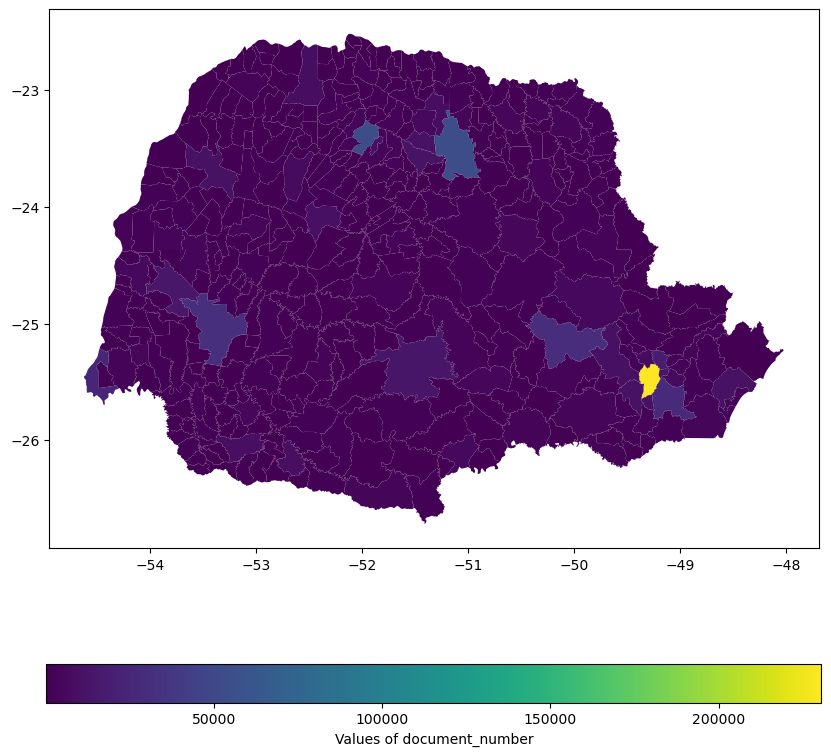


Map of cities by mean share capital:


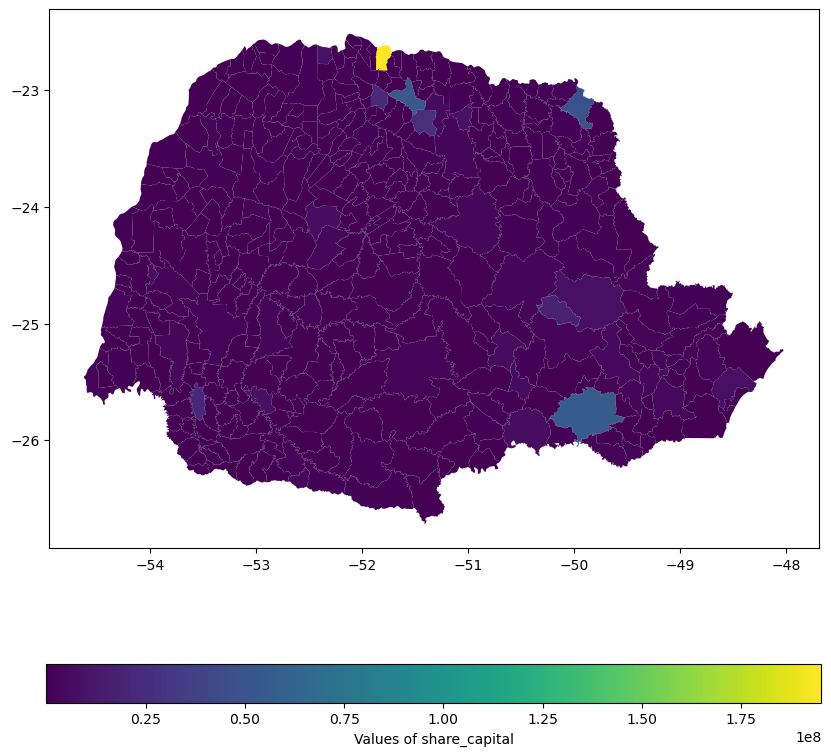

In [12]:
values_and_operations = {'share_capital': 'mean',
                         'document_number': 'nunique'}

pivot_df = pivot_data(df=df,
                      index_columns=['city_code'],
                      values_and_operations={'share_capital': 'mean',
                                             'document_number': 'nunique'})

print('Pivot table with mean share capital and count of CNPJs per city in Paraná:')
display(pivot_df.head(10))

map_df = join_dfs(df_1=gdf[['code_muni', 'geometry']],
                  df_2=pivot_df,
                  left_on='code_muni',
                  right_on='city_code',
                  how='inner')

print('\nMerged pivot table with geometry table:')
display(map_df.head(10))

print('\nMap of cities by CNPJ count:')

fig_1, ax_1 = plot_city_data(gdf=map_df,
                             variable='document_number')
display(fig_1)

print('\nMap of cities by mean share capital:')

fig_2, ax_2 = plot_city_data(gdf=map_df,
                             variable='share_capital')
display(fig_2)

So it depends on selling volume or value. If our ticket is lower we would instantly think of Greater Curitiba, Cascavel, Londrina and Maringá. 

If we do not need to sell as much of our product, but can command a higher ticket, some countryside cities look interesting. However, this higher mean ticket can be derived from a **low sample size of companies**, so it is probably better to stay with the larger cities as most of the bigger companies will be there, even if there are lots of smaller ones to offset them and lower the mean share capital.

<br>

### If you were to make any model from the data, which one do you think makes sense?

If we have several variants of a new product and expect each one of them to have a different persona, then we might run a clustering model. Then we can try matching each cluster to a persona and be more precise with our sales.

However, let's say we have an existing product and would like to enter the Paraná state market. We might be interested in running a classification model. An example would be a logistic regression (0 = no deal and 1 = deal from CRM data) to rank the most probable leads to close a deal.

If we did so, we might not even need to define a decision boundary because the probability output is already useful in ranking leads, maybe even more so.

Even a linear model where the target is revenue from each company might help in recommending leads, so we can know which ones would be more propense to buy big. However, that only works if we have many products with different values, else it would be a waste.

In that case, we could even plot the results from the regression and the classification models to get the ones with high probability of buying the product and spending a lot.

Depending on the amount of different products we sell, an actual recommendation system could also be useful.